# Metropolis-Hastings sampling of MLP weights using XOR data

Learn the XOR function by sampling the weights of a multi-layer perceptron (MLP) via the Metropolis-Hastings algorithm.

In [1]:
## Import packages

import numpy as np

import torch

from torch.utils.data import DataLoader
from torch.distributions import Normal

from eeyore.api import indexify
from eeyore.data import XOR
from eeyore.models import mlp
from eeyore.kernels import NormalKernel
from eeyore.mcmc import MetropolisHastings

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## Load XOR data

xor = indexify(XOR)(dtype=torch.float64)
dataloader = DataLoader(xor, batch_size=4)

In [3]:
## Setup MLP model

hparams = mlp.Hyperparameters(dims=[2, 2, 1])
model = mlp.MLP(hparams=hparams, dtype=torch.float64)
model.prior = Normal(
    torch.zeros(model.num_params(), dtype=model.dtype),
    np.sqrt(3)*torch.ones(model.num_params(), dtype=model.dtype)
)

In [4]:
## Setup Metropolis-Hastings sampler

theta0 = model.prior.sample()
num_params = model.num_params()
proposal_scale = np.sqrt(1.55)
kernel = NormalKernel(
    torch.zeros(num_params),
    proposal_scale * torch.ones(num_params),
    dtype=torch.float64
)
sampler = MetropolisHastings(model, theta0, dataloader, kernel)

In [5]:
## Run Metropolis-Hastings sampler

sampler.run(num_iterations=11000, num_burnin=1000)

In [6]:
## Compute acceptance rate

sampler.chain.acceptance_rate()

0.3255000114440918

In [7]:
## Compute Monte Carlo mean

sampler.chain.mean()

tensor([-0.0885,  0.0363,  0.0185,  0.1024,  0.0687, -0.1621,  0.0824,  0.1240,
        -0.1080], dtype=torch.float64)

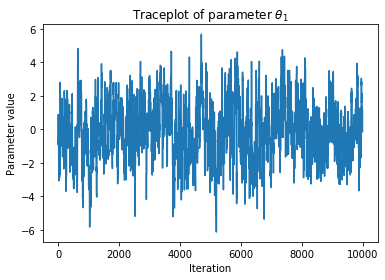

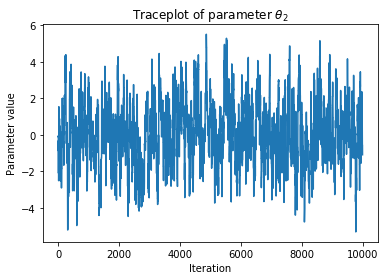

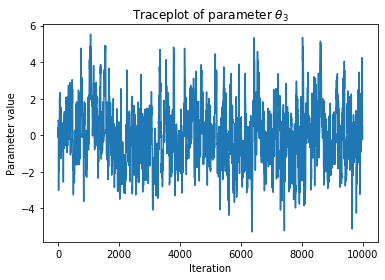

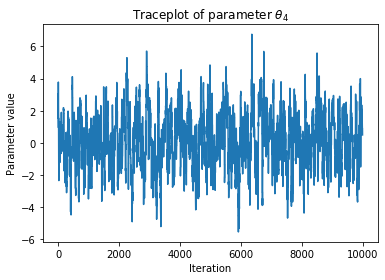

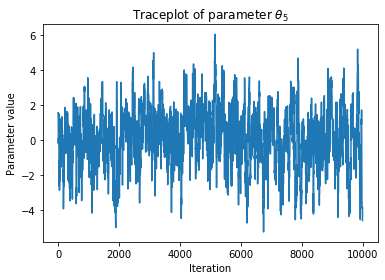

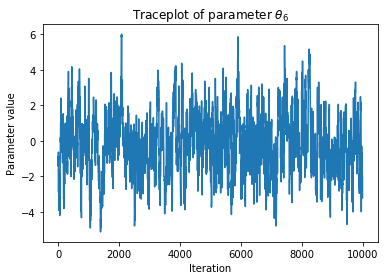

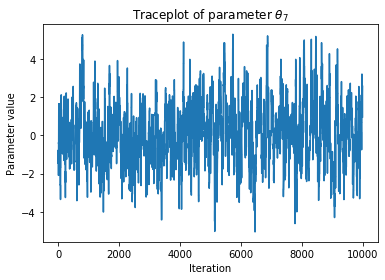

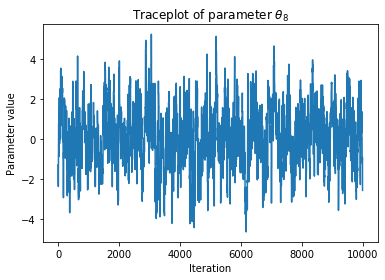

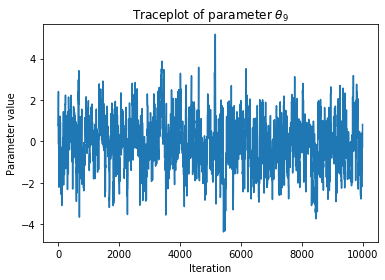

In [8]:
## Plot traces of simulated Markov chain

for i in range(model.num_params()):
    chain = sampler.chain.get_theta(i)
    plt.figure()
    sns.lineplot(range(len(chain)), chain)
    plt.xlabel('Iteration')
    plt.ylabel('Parameter value')
    plt.title(r'Traceplot of parameter $\theta_{}$'.format(i+1))

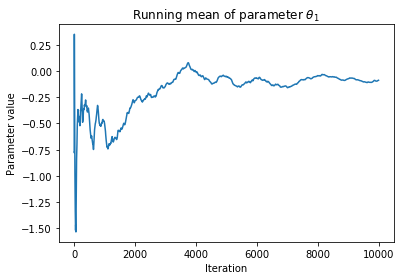

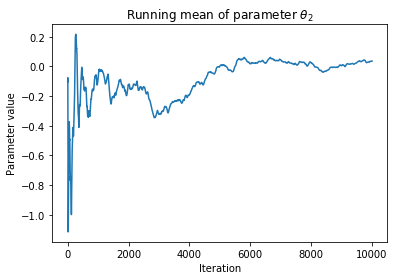

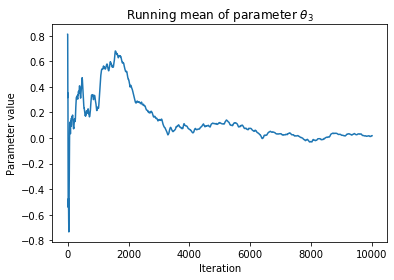

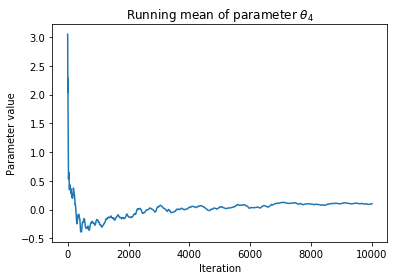

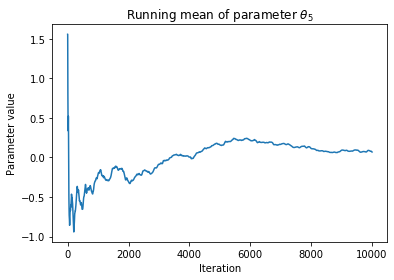

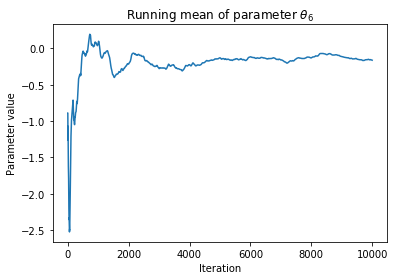

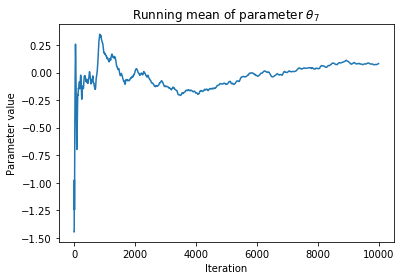

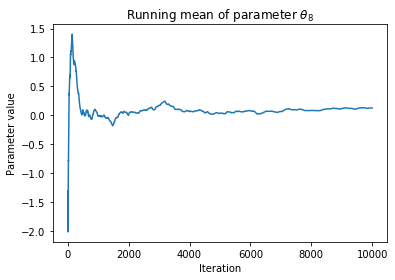

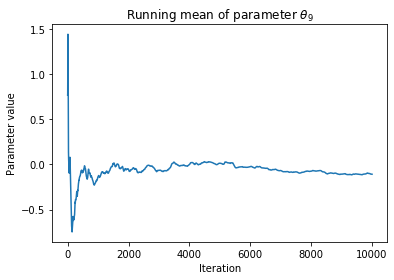

In [9]:
## Plot running means of simulated Markov chain

for i in range(model.num_params()):
    chain = sampler.chain.get_theta(i)
    chain_mean = torch.empty(len(chain))
    chain_mean[0] = chain[0]
    for j in range(1, len(chain)):
        chain_mean[j] = (chain[j]+j*chain_mean[j-1])/(j+1)
        
    plt.figure()
    sns.lineplot(range(len(chain)), chain_mean)
    plt.xlabel('Iteration')
    plt.ylabel('Parameter value')
    plt.title(r'Running mean of parameter $\theta_{}$'.format(i+1))

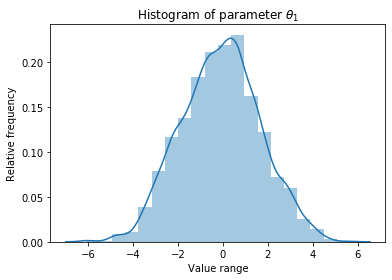

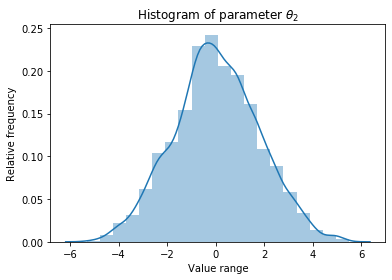

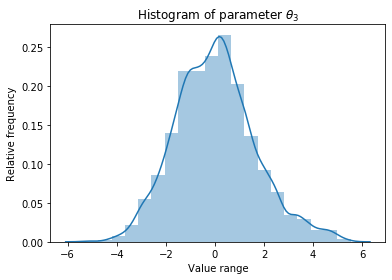

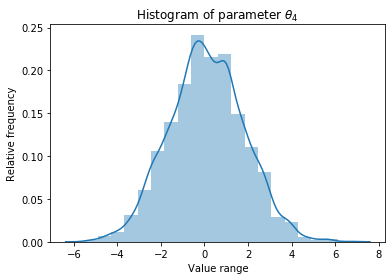

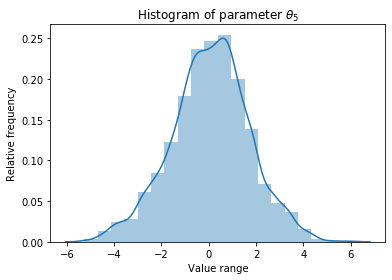

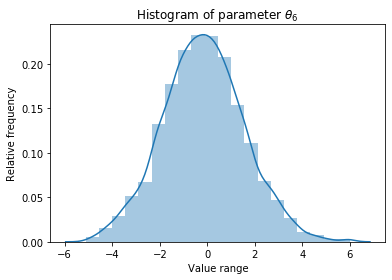

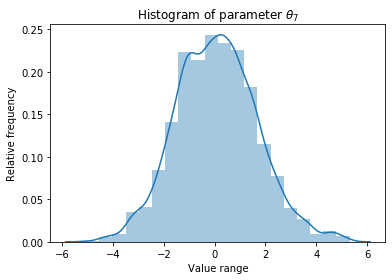

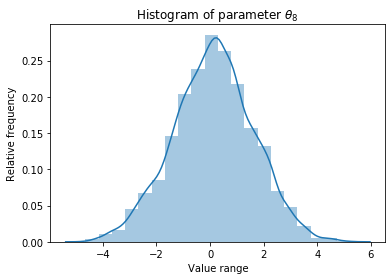

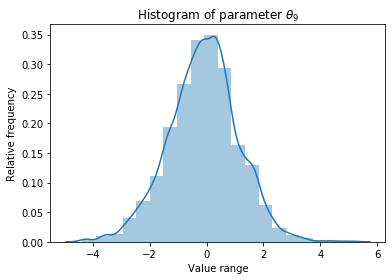

In [10]:
## Plot histograms of simulated Markov chain

for i in range(model.num_params()):
    plt.figure()
    sns.distplot(sampler.chain.get_theta(i), bins=20, norm_hist=True)
    plt.xlabel('Value range')
    plt.ylabel('Relative frequency')
    plt.title(r'Histogram of parameter $\theta_{}$'.format(i+1))